# Final project

### Imports

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
# Needed for training
from torch.optim.lr_scheduler import StepLR

### Set device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Definitions

In [3]:
NUM_CLASSES = 10
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
def get_args():   
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', default=0, type=int, help='Seed for random number generators')
    parser.add_argument('--data-path', default="/datasets/cv_datasets/data", type=str, help='Path to dataset')
    parser.add_argument('--batch-size', default=8, type=int, help='Size of each batch')
    parser.add_argument('--latent-dim', default=128, type=int, help='encoding dimension')
    parser.add_argument('--device', default='cuda' if torch.cuda.is_available() else 'cpu', type=str, help='Default device to use')
    parser.add_argument('--mnist', action='store_true', default=False,
                        help='Whether to use MNIST (True) or CIFAR10 (False) data')
    parser.add_argument('--self-supervised', action='store_true', default=False,
                        help='Whether train self-supervised with reconstruction objective, or jointly with classifier for classification objective.')
    return parser.parse_args()

### Data Set download

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define where to save the dataset
mnist_path = "./mnist_data"

# Define transformations (convert to tensor + normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # MNIST is grayscale, so only one channel
])

# Load and download MNIST with the transform
train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


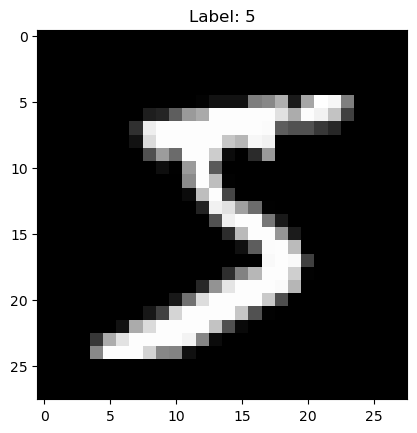

In [5]:
import matplotlib.pyplot as plt

# Get an image and its label
image, label = train_dataset[0]

# Convert tensor to NumPy and display it
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### Data Loader

In [6]:
from torch.utils.data import random_split, DataLoader

train_size = 50_000
val_size = 10_000

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


batch_size = 64

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([8, 1, 9, 9, 1])


### MNIST Autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt  # Add this for plotting


# Device configuration (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MNISTAutoencoder(nn.Module):
    def __init__(self, latent_dim=128,dropout_prob = 0.1):
        super(MNISTAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output between -1 and 1
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

def train_autoencoder(model, train_loader, val_loader, num_epochs=20, learning_rate=1e-4):
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store losses
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():  # No gradient computation for validation
            for data, _ in val_loader:
                data = data.to(device)
                reconstructed, _ = model(data)
                loss = criterion(reconstructed, data)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()



### MNIST Autoencoder training 

Epoch [1/25], Train Loss: 0.5277, Val Loss: 0.3993
Epoch [2/25], Train Loss: 0.4064, Val Loss: 0.3706
Epoch [3/25], Train Loss: 0.3891, Val Loss: 0.3606
Epoch [4/25], Train Loss: 0.3809, Val Loss: 0.3543
Epoch [5/25], Train Loss: 0.3760, Val Loss: 0.3513
Epoch [6/25], Train Loss: 0.3723, Val Loss: 0.3483
Epoch [7/25], Train Loss: 0.3694, Val Loss: 0.3460
Epoch [8/25], Train Loss: 0.3674, Val Loss: 0.3446
Epoch [9/25], Train Loss: 0.3655, Val Loss: 0.3439
Epoch [10/25], Train Loss: 0.3641, Val Loss: 0.3418
Epoch [11/25], Train Loss: 0.3626, Val Loss: 0.3407
Epoch [12/25], Train Loss: 0.3617, Val Loss: 0.3402
Epoch [13/25], Train Loss: 0.3608, Val Loss: 0.3388
Epoch [14/25], Train Loss: 0.3600, Val Loss: 0.3384
Epoch [15/25], Train Loss: 0.3592, Val Loss: 0.3381
Epoch [16/25], Train Loss: 0.3585, Val Loss: 0.3374
Epoch [17/25], Train Loss: 0.3579, Val Loss: 0.3370
Epoch [18/25], Train Loss: 0.3572, Val Loss: 0.3364
Epoch [19/25], Train Loss: 0.3568, Val Loss: 0.3365
Epoch [20/25], Train 

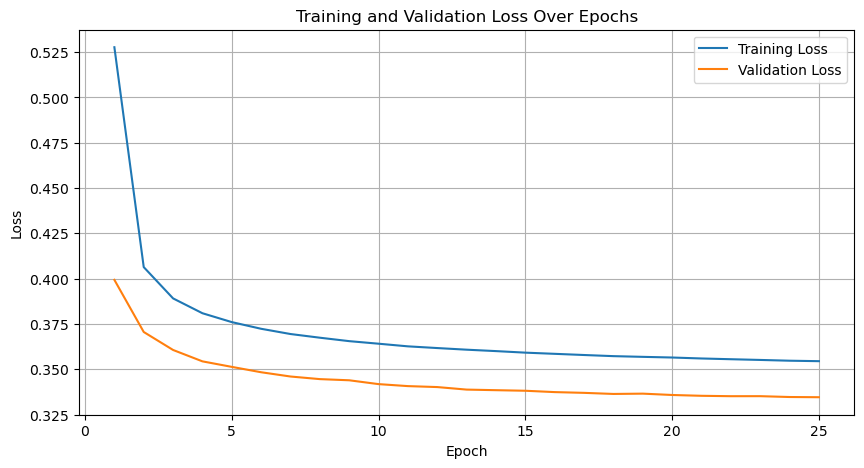

In [8]:

# Model initialization
model = MNISTAutoencoder(latent_dim=128).to(device)

# Train and plot
train_autoencoder(model, mnist_train_loader, mnist_val_loader, num_epochs=25, learning_rate=0.0001)

### MNIST classifier

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# 1. Extract and freeze the pre-trained encoder
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Freeze encoder weights

# 2. Define the classifier
class MNISTClassifier(nn.Module):
    def __init__(self, latent_dim=128):
        super(MNISTClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

# 3. Training function
def train_classifier(encoder, classifier, train_loader, val_loader, num_epochs=15, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    # Optimize only classifier parameters
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    
    classifier = classifier.to(device)
    encoder = encoder.to(device)
    encoder.eval()  # Set encoder to evaluation mode
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        classifier.train()
        total_train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            # Get latent representation (no gradients through encoder)
            with torch.no_grad():
                latent = encoder(data) # Transform images to latent space
            
            optimizer.zero_grad()
            output = classifier(latent) # The output is the classifier classification from the latent space
            loss = criterion(output, target) 
            loss.backward()  # Backprop only through classifier
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                latent = encoder(data)
                output = classifier(latent)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage
model.eval()
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen



In [10]:
### Train Classifier

Epoch [1/15], Train Loss: 0.2097, Val Accuracy: 96.53%
Epoch [2/15], Train Loss: 0.1115, Val Accuracy: 96.94%
Epoch [3/15], Train Loss: 0.0851, Val Accuracy: 97.37%
Epoch [4/15], Train Loss: 0.0721, Val Accuracy: 97.63%
Epoch [5/15], Train Loss: 0.0611, Val Accuracy: 97.60%
Epoch [6/15], Train Loss: 0.0555, Val Accuracy: 97.78%
Epoch [7/15], Train Loss: 0.0521, Val Accuracy: 97.65%
Epoch [8/15], Train Loss: 0.0463, Val Accuracy: 97.88%
Epoch [9/15], Train Loss: 0.0417, Val Accuracy: 97.78%
Epoch [10/15], Train Loss: 0.0417, Val Accuracy: 97.79%
Epoch [11/15], Train Loss: 0.0352, Val Accuracy: 97.87%
Epoch [12/15], Train Loss: 0.0318, Val Accuracy: 97.92%
Epoch [13/15], Train Loss: 0.0340, Val Accuracy: 97.92%
Epoch [14/15], Train Loss: 0.0303, Val Accuracy: 97.79%
Epoch [15/15], Train Loss: 0.0303, Val Accuracy: 97.76%


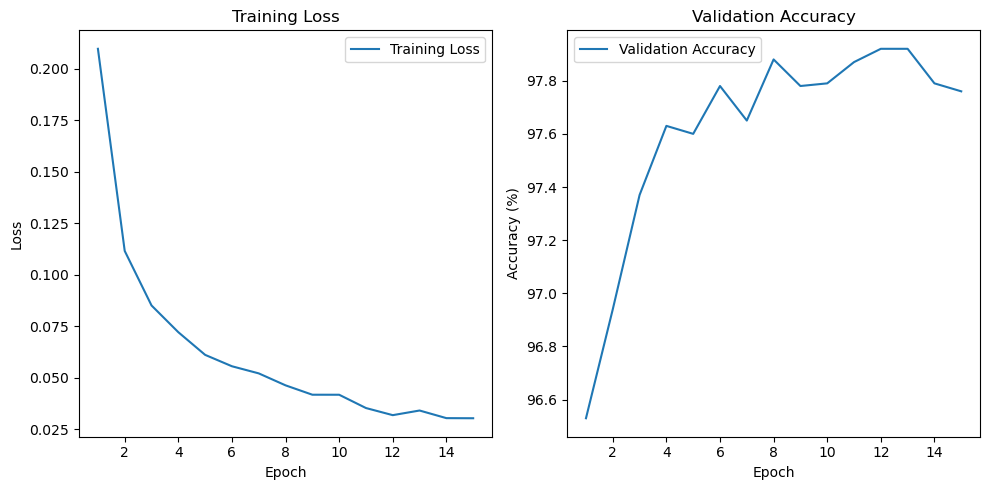

In [11]:
classifier = MNISTClassifier(latent_dim=128)
train_classifier(pretrained_encoder, classifier, mnist_train_loader, mnist_val_loader)

### Sanity Check - too good to be true??

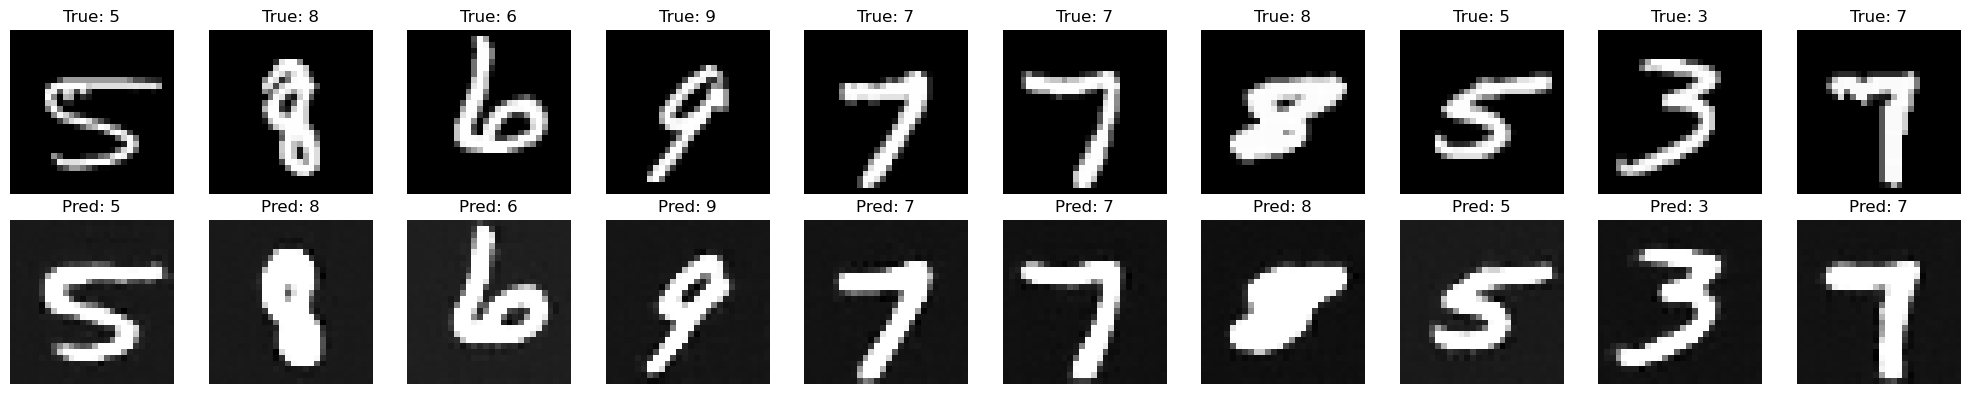


Results:
Image | True Label | Predicted Label | Correct
---------------------------------------------
    0 |           5 |              5 | Yes
    1 |           8 |              8 | Yes
    2 |           6 |              6 | Yes
    3 |           9 |              9 | Yes
    4 |           7 |              7 | Yes
    5 |           7 |              7 | Yes
    6 |           8 |              8 | Yes
    7 |           5 |              5 | Yes
    8 |           3 |              3 | Yes
    9 |           7 |              7 | Yes


In [12]:

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Assuming 'model' is the trained autoencoder and 'classifier' is the trained classifier

def analyze_images(autoencoder, classifier, val_loader, num_images=10):
    autoencoder.eval()
    classifier.eval()
    
    # Randomly select indices
    indices = np.random.choice(len(val_dataset), num_images, replace=False)
    images = torch.stack([val_dataset[i][0] for i in indices])
    labels = torch.tensor([val_dataset[i][1] for i in indices])
    
    images = images.to(device)
    labels = labels.to(device)
    
    # 1. Reconstruct images through autoencoder
    with torch.no_grad():
        reconstructed, latent = autoencoder(images)
    
    # 2. Get classifications from classifier
    with torch.no_grad():
        class_outputs = classifier(latent)
        _, predictions = torch.max(class_outputs, 1)
    
    # 3. Prepare for visualization
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    
    # 4. Plot original vs reconstructed with predictions
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
    
    for i in range(num_images):
        # Original images (top row)
        axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'True: {labels[i]}')
        
        # Reconstructed images (bottom row)
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Pred: {predictions[i]}')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Print results
    print("\nResults:")
    print("Image | True Label | Predicted Label | Correct")
    print("-" * 45)
    for i in range(num_images):
        correct = "Yes" if labels[i] == predictions[i] else "No"
        print(f"{i:5d} | {labels[i]:11d} | {predictions[i]:14d} | {correct}")

# Run the analysis
analyze_images(model, classifier, test_loader, num_images=10)

### Mnist 1.2.1 is done

# Cifar10

### Data Set download

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define where to save the dataset
cifar10_path = "./cifar10_data"

# Define transformations (convert to tensor + normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # CIFAR-10 has 3 channels (RGB)
])

# Load and download CIFAR-10 with the transform
c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


torch.Size([3, 32, 32])


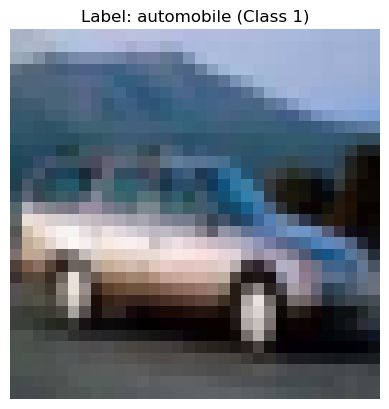

In [14]:
# CIFAR-10 class names for better labeling
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get an image and its label
image, label = c10_full_train_dataset[4]
print(image.shape)
# Unnormalize the image for display (reverse the normalization)
image = image * torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)

# Convert tensor from (C, H, W) to (H, W, C) for Matplotlib
image = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image)
plt.title(f"Label: {class_names[label]} (Class {label})")
plt.axis('off')  # Optional: hide axes for cleaner display
plt.show()

### Data loader

In [15]:
from torch.utils.data import random_split, DataLoader

# Define sizes for splitting the training dataset
train_size = 40_000
val_size = 10_000

# Use random_split to split the training dataset
c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")

# Define batch size
batch_size = 64

# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 3, 32, 32]), Labels (first 5): tensor([4, 3, 7, 0, 0])


### Cifar Autoencoder

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt



# Device configuration (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RevisedCIFAR10Autoencoder(nn.Module):
    def __init__(self, latent_dim=128,dropout_prob = 0.1):
        super(RevisedCIFAR10Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),    # 32x32x3 -> 32x32x64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 32x32x64 -> 16x16x128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # 16x16x128 -> 8x8x256
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1), # Refine: 8x8x256 -> 8x8x256
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Flatten(),                                # 8x8x256 = 16384
            nn.Linear(256 * 8 * 8, latent_dim),          # 16384 -> 128
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)                   # Reduced dropout
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),          # 128 -> 16384
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Unflatten(1, (256, 8, 8)),               # Reshape to 8x8x256
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 8x8x256 -> 16x16x128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 16x16x128 -> 32x32x64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),   # Refine: 32x32x64 -> 32x32x64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),    # 32x32x64 -> 32x32x3
            nn.Tanh()                                    # Output [-1, 1]
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

In [17]:
def train_autoencoder(model, train_loader, val_loader, num_epochs=30, learning_rate=5e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=15, gamma=0.1)  # Reduce LR every 15 epochs
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                reconstructed, _ = model(data)
                loss = criterion(reconstructed, data)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/30], Train Loss: 0.3420, Val Loss: 0.2550, LR: 0.000500
Epoch [2/30], Train Loss: 0.2774, Val Loss: 0.2324, LR: 0.000500
Epoch [3/30], Train Loss: 0.2639, Val Loss: 0.2243, LR: 0.000500
Epoch [4/30], Train Loss: 0.2578, Val Loss: 0.2191, LR: 0.000500
Epoch [5/30], Train Loss: 0.2536, Val Loss: 0.2156, LR: 0.000500
Epoch [6/30], Train Loss: 0.2496, Val Loss: 0.2112, LR: 0.000500
Epoch [7/30], Train Loss: 0.2467, Val Loss: 0.2094, LR: 0.000500
Epoch [8/30], Train Loss: 0.2438, Val Loss: 0.2131, LR: 0.000500
Epoch [9/30], Train Loss: 0.2412, Val Loss: 0.2084, LR: 0.000500
Epoch [10/30], Train Loss: 0.2381, Val Loss: 0.2105, LR: 0.000500
Epoch [11/30], Train Loss: 0.2357, Val Loss: 0.2100, LR: 0.000500
Epoch [12/30], Train Loss: 0.2330, Val Loss: 0.2097, LR: 0.000500
Epoch [13/30], Train Loss: 0.2309, Val Loss: 0.2062, LR: 0.000500
Epoch [14/30], Train Loss: 0.2286, Val Loss: 0.2071, LR: 0.000500
Epoch [15/30], Train Loss: 0.2264, Val Loss: 0.2038, LR: 0.000050
Epoch [16/30], Trai

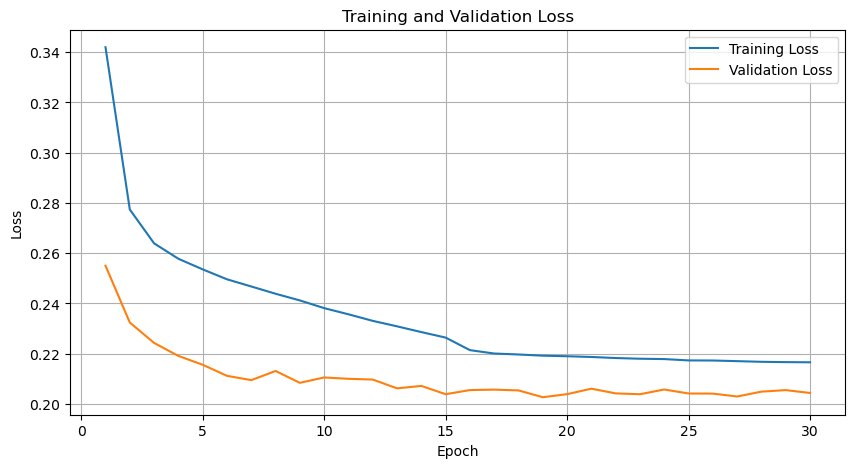

In [18]:
model = RevisedCIFAR10Autoencoder(latent_dim=128).to(device)
train_autoencoder(model, c10_train_loader, c10_val_loader, num_epochs=30, learning_rate=5e-4)

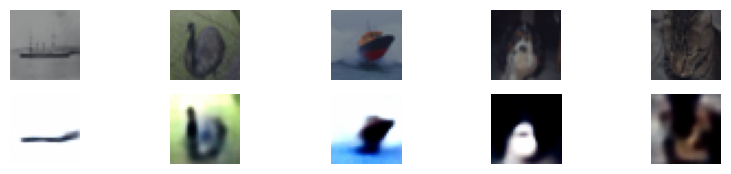

In [19]:
# Visualize reconstructions
model.eval()
with torch.no_grad():
    data, _ = next(iter(c10_val_loader))
    data = data.to(device)
    reconstructed, _ = model(data)
    data = data * 0.1307 + 0.3081  # Unnormalize
    reconstructed = reconstructed * 0.5 + 0.5
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(data[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(reconstructed[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
    plt.show()

### Cifar classifier (Same as MNIST)

In [26]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, latent_dim=128):
        super(CIFAR10Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        return self.classifier(x)

# Training function with scheduler
def train_classifier(encoder, classifier, train_loader, val_loader, num_epochs=50, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    classifier = classifier.to(device)
    encoder = encoder.to(device)
    encoder.eval()
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        classifier.train()
        total_train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                latent = encoder(data)
            optimizer.zero_grad()
            output = classifier(latent)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                latent = encoder(data)
                output = classifier(latent)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}')
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [41]:
def test_classifier(encoder, classifier, test_loader):
    classifier.eval()
    encoder.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            latent = encoder(data)
            output = classifier(latent)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

### Train Cifar classifier

In [ ]:
autoencoder = RevisedCIFAR10Autoencoder(latent_dim=128).to(device)
# Assume autoencoder is pre-trained; if not, train it first
pretrained_encoder = autoencoder.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False
classifier = CIFAR10Classifier(latent_dim=128).to(device)
train_classifier(encoder = pretrained_encoder, 
                 classifier= classifier, 
                 train_loader = c10_train_loader,
                 val_loader = c10_val_loader,
                 num_epochs=40, 
                 learning_rate=1e-2)

In [42]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_val_loader)

Test Accuracy: 39.18%
